# Sentiment Analysis (NLP)

*We have 40k movie reviews on train data and 10k on the test data. Our aim is to identify whether it's positive or negative using Natural Language.*

What should be done for this task in the notebook:
- EDA (with some conclusions)
- Text preprocessing (comparing some techniques)
- Modeling (with accuracy over 85%)

## EDA

In [99]:
# Imports
import warnings
import os
import sys
import string
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sbn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression         
from sklearn.naive_bayes import GaussianNB

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from spellchecker import SpellChecker

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from keras.models import Sequential



In [2]:
#Customize warnings
warnings.filterwarnings("ignore")

#Assigning folder to store plots
PLOT_DIR = os.path.dirname((os.getcwd()))+'/outputs/figures'
def save_fig(fig_name:str):
    if not os.path.exists(PLOT_DIR):
        os.makedirs(PLOT_DIR)
    save_path = os.path.join(PLOT_DIR, fig_name)
    plt.savefig(save_path, format='jpg', dpi=300)



In [3]:
#Loading the data 
sentiment = pd.read_csv("../data/raw/train.csv")
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     40000 non-null  object
 1   sentiment  40000 non-null  object
dtypes: object(2)
memory usage: 625.1+ KB


- Feature distribution

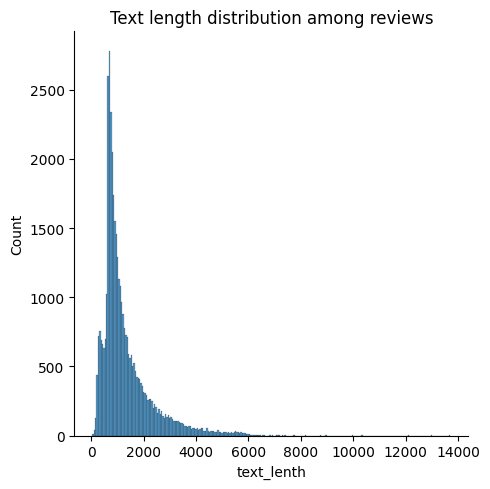

In [4]:
sentiment['text_lenth'] = sentiment['review'].apply(lambda x: len(x))
sbn.displot(data=sentiment,x = 'text_lenth')
plt.title("Text length distribution among reviews")
plt.tight_layout()
save_fig(fig_name='txt_len_dist.jpg')

- Target analysis

In [5]:
pos = 'Percentage of positive sentiments',len(sentiment[sentiment['sentiment'] == 'positive']) / len(sentiment)*100
neg = 'Percentage of negative sentiments',len(sentiment[sentiment['sentiment'] == 'negative']) / len(sentiment)*100
print(pos,'\n',neg)

('Percentage of positive sentiments', 50.0) 
 ('Percentage of negative sentiments', 50.0)


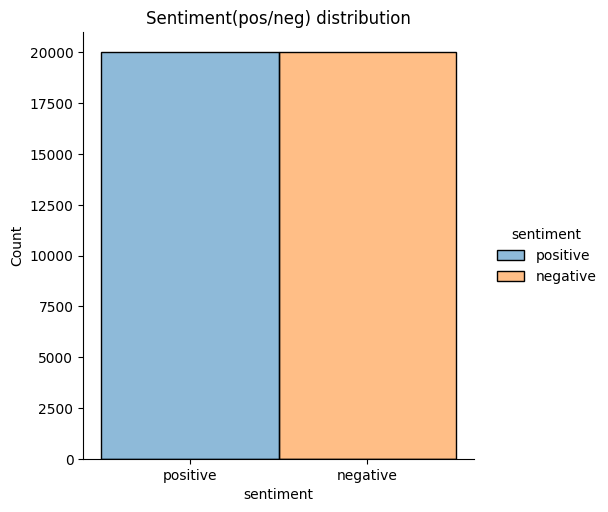

In [6]:
sbn.displot(data=sentiment,x='sentiment',hue='sentiment')
plt.title("Sentiment(pos/neg) distribution")
save_fig(fig_name='sent_dist.jpg')

## Text Preprocessing

What should be done for this part:
- Lower casing
- Removing irrelevant characters (punctuations, numbers) 
- Tokenization
- Removing stopwords
- Stemming vs Lemmatization
- Removing URLs and HTML tags


In [7]:
sentiment.drop(columns=['text_lenth'],inplace = True)
original_data = sentiment.copy()

### Basic cleaning

In [8]:
#lower casing
sentiment['review'] = sentiment['review'].str.lower() 

#removing urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
sentiment["review"] = sentiment["review"].apply(lambda text: remove_urls(text))

#removing html tags (they appear so often in text)
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
sentiment["review"] = sentiment["review"].apply(lambda text: remove_html(text))    

#removing non-alpha-numeric chars
def remove_non_alpha_numeric(text):
    return re.sub('[^a-zA-Z]',' ',text)
sentiment["review"] = sentiment["review"].apply(lambda text: remove_non_alpha_numeric(text))    


Original text vs cleaned text so far:

In [9]:
print(original_data['review'][100][:300],'\n------------------\n',sentiment['review'][100][:300])

Aubrey Davis (Amber Tamblyn) travels to Tokyo to investigate the mysterious disappearance of her sister Karen (Sarah Michelle Gellar) and gets caught up in the same mysterious curse that has killed so many people. With a group of others, she tries to solve and end the curse for good.<br /><br />The  
------------------
 aubrey davis  amber tamblyn  travels to tokyo to investigate the mysterious disappearance of her sister karen  sarah michelle gellar  and gets caught up in the same mysterious curse that has killed so many people  with a group of others  she tries to solve and end the curse for good the grudge   reh


- Tokenization

In [10]:
def tokenize(text):
    return word_tokenize(text)
sentiment['review_tokenized'] = sentiment['review'].apply(tokenize)


Original text vs tokenized text so far:

In [11]:
print(sentiment['review'][100][:300],'\n------------------\n',sentiment['review_tokenized'][100][:45])

aubrey davis  amber tamblyn  travels to tokyo to investigate the mysterious disappearance of her sister karen  sarah michelle gellar  and gets caught up in the same mysterious curse that has killed so many people  with a group of others  she tries to solve and end the curse for good the grudge   reh 
------------------
 ['aubrey', 'davis', 'amber', 'tamblyn', 'travels', 'to', 'tokyo', 'to', 'investigate', 'the', 'mysterious', 'disappearance', 'of', 'her', 'sister', 'karen', 'sarah', 'michelle', 'gellar', 'and', 'gets', 'caught', 'up', 'in', 'the', 'same', 'mysterious', 'curse', 'that', 'has', 'killed', 'so', 'many', 'people', 'with', 'a', 'group', 'of', 'others', 'she', 'tries', 'to', 'solve', 'and', 'end']


- Stemming vs Lemmatization

In [12]:
stemmer = PorterStemmer()
def stem(token):
    return [stemmer.stem(i) for i in token]

sentiment['stem_review'] = sentiment['review_tokenized'].apply(stem)

As can be seen here some words like `investigate` stemmed to `investig` which has no any meaning. To avoid this let's use lematization technique which lemmatizez the word to its root form in dictionary.

In [13]:
print(sentiment['stem_review'][100][:45],'\n------------------\n',sentiment['review_tokenized'][100][:45])

['aubrey', 'davi', 'amber', 'tamblyn', 'travel', 'to', 'tokyo', 'to', 'investig', 'the', 'mysteri', 'disappear', 'of', 'her', 'sister', 'karen', 'sarah', 'michel', 'gellar', 'and', 'get', 'caught', 'up', 'in', 'the', 'same', 'mysteri', 'curs', 'that', 'ha', 'kill', 'so', 'mani', 'peopl', 'with', 'a', 'group', 'of', 'other', 'she', 'tri', 'to', 'solv', 'and', 'end'] 
------------------
 ['aubrey', 'davis', 'amber', 'tamblyn', 'travels', 'to', 'tokyo', 'to', 'investigate', 'the', 'mysterious', 'disappearance', 'of', 'her', 'sister', 'karen', 'sarah', 'michelle', 'gellar', 'and', 'gets', 'caught', 'up', 'in', 'the', 'same', 'mysterious', 'curse', 'that', 'has', 'killed', 'so', 'many', 'people', 'with', 'a', 'group', 'of', 'others', 'she', 'tries', 'to', 'solve', 'and', 'end']


When we lemmatize some words like `running` it stays as it is not `run` because `running` is in noun form. So let's  lemmatize by providing the POS tag for the word.

In [14]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

sentiment["lemma_review"] = sentiment["review"].apply(lambda text: lemmatize_words(text))
sentiment['lemma_review_tokenized'] = sentiment['lemma_review'].apply(tokenize)

In [15]:
print(sentiment['lemma_review_tokenized'][100][:45],'\n------------------\n',sentiment['review_tokenized'][100][:45])

['aubrey', 'davis', 'amber', 'tamblyn', 'travel', 'to', 'tokyo', 'to', 'investigate', 'the', 'mysterious', 'disappearance', 'of', 'her', 'sister', 'karen', 'sarah', 'michelle', 'gellar', 'and', 'get', 'catch', 'up', 'in', 'the', 'same', 'mysterious', 'curse', 'that', 'have', 'kill', 'so', 'many', 'people', 'with', 'a', 'group', 'of', 'others', 'she', 'try', 'to', 'solve', 'and', 'end'] 
------------------
 ['aubrey', 'davis', 'amber', 'tamblyn', 'travels', 'to', 'tokyo', 'to', 'investigate', 'the', 'mysterious', 'disappearance', 'of', 'her', 'sister', 'karen', 'sarah', 'michelle', 'gellar', 'and', 'gets', 'caught', 'up', 'in', 'the', 'same', 'mysterious', 'curse', 'that', 'has', 'killed', 'so', 'many', 'people', 'with', 'a', 'group', 'of', 'others', 'she', 'tries', 'to', 'solve', 'and', 'end']


Let's remove the words that have length less than two (like 'a','is','the', etc) as they've not very meaningful 

In [16]:
def clean_small_length(token):
    return [i for i in token if len(i)>2]
sentiment['cleaned_review'] = sentiment['lemma_review_tokenized'].apply(clean_small_length)
print(sentiment['cleaned_review'][100][:45])

['aubrey', 'davis', 'amber', 'tamblyn', 'travel', 'tokyo', 'investigate', 'the', 'mysterious', 'disappearance', 'her', 'sister', 'karen', 'sarah', 'michelle', 'gellar', 'and', 'get', 'catch', 'the', 'same', 'mysterious', 'curse', 'that', 'have', 'kill', 'many', 'people', 'with', 'group', 'others', 'she', 'try', 'solve', 'and', 'end', 'the', 'curse', 'for', 'good', 'the', 'grudge', 'rehash', 'everything', 'from']


Now let's convert back those cleaned tokens to string for further analysis.

In [17]:
def convert_to_string(token):
    return " ".join(token)
sentiment['cleaned_review'] = sentiment['cleaned_review'].apply(convert_to_string)
print(sentiment['cleaned_review'][100][:310])

aubrey davis amber tamblyn travel tokyo investigate the mysterious disappearance her sister karen sarah michelle gellar and get catch the same mysterious curse that have kill many people with group others she try solve and end the curse for good the grudge rehash everything from the first one and produce only


- Text vizualization

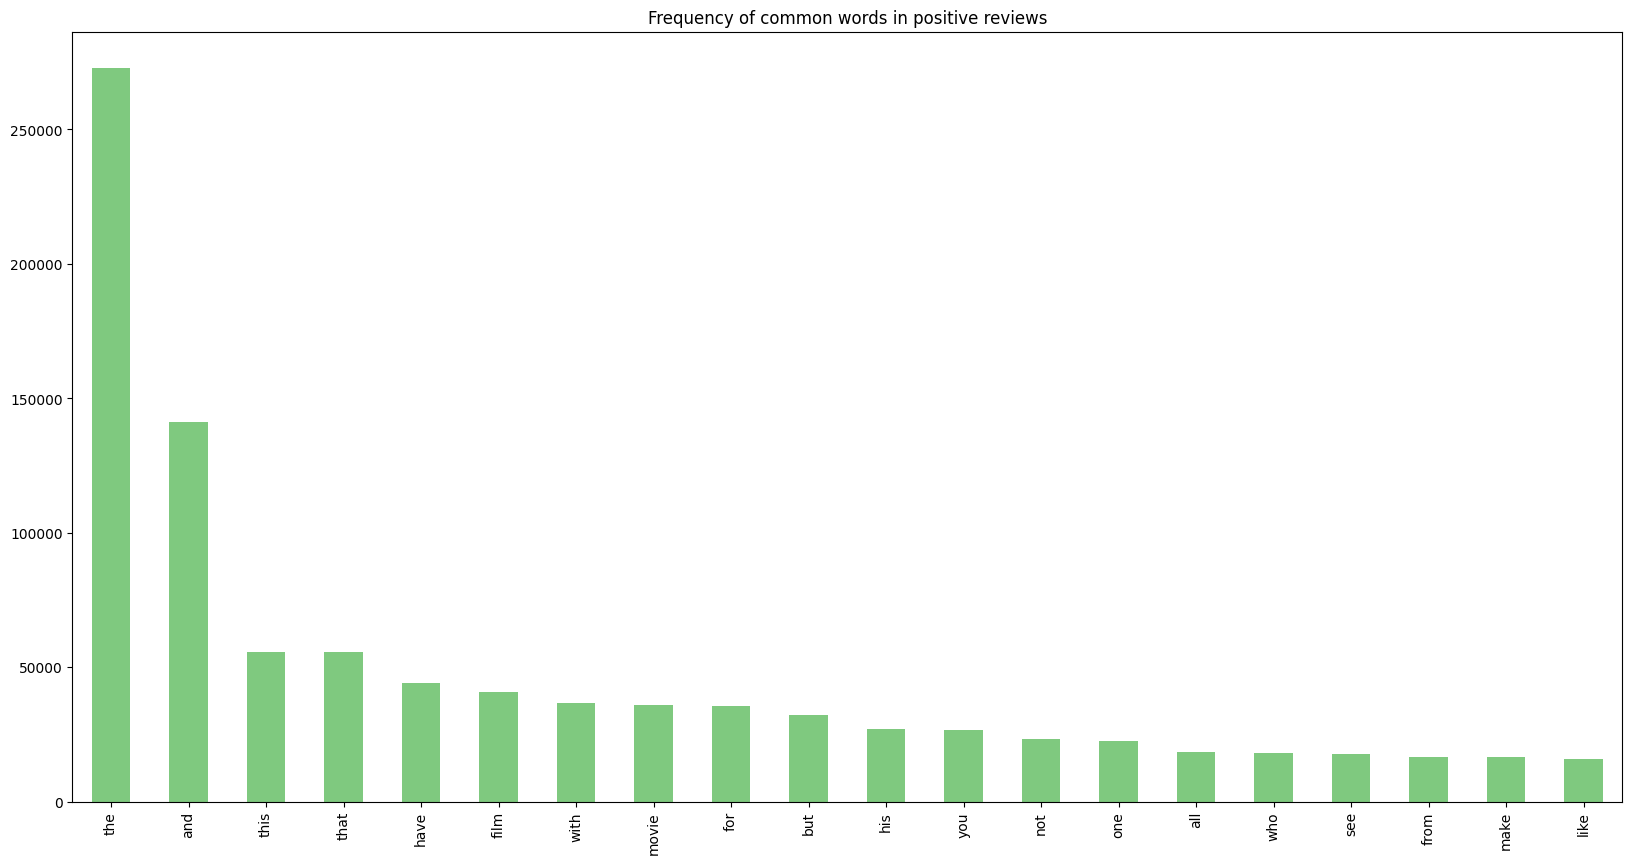

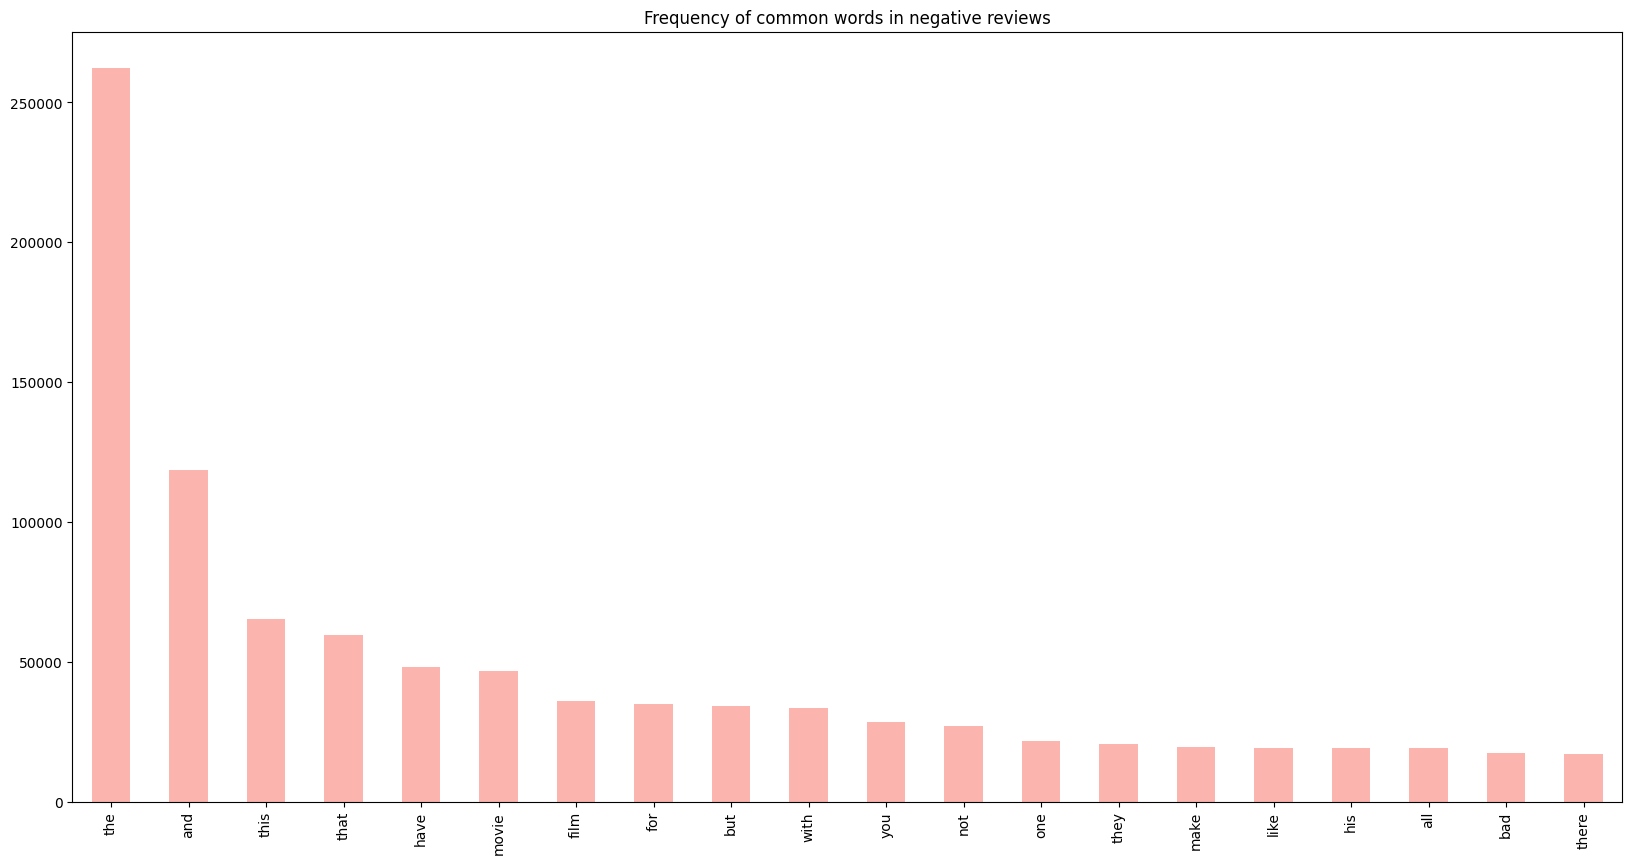

In [18]:
PosRev = sentiment[sentiment['sentiment']=='positive']['cleaned_review']
NegRev = sentiment[sentiment['sentiment']=='negative']['cleaned_review']

colors = ['Accent','Pastel1']
data = [PosRev,NegRev]
labels = ['positive','negative']
for item in range(2):
    plt.figure(figsize=(20,10))
    pd.Series(' '.join([i for i in data[item]]).split()).value_counts().head(20).plot(kind='bar',colormap=colors[item])
    plt.title(f"Frequency of common words in {labels[item]} reviews")
    plt.show()

Well, I think one more thing left here: **removing stopwords**<br>
`But before removing all words stopwords list let's filter (not to delete) some important words for negation (not,nor,never)`

In [19]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    additional_words_to_keep = ['not', 'never', 'nor']
    return " ".join([word for word in str(text).split() if (word not in STOPWORDS) or (word in additional_words_to_keep)])
sentiment["cleaned_review"] = sentiment["cleaned_review"].apply(lambda text: remove_stopwords(text))

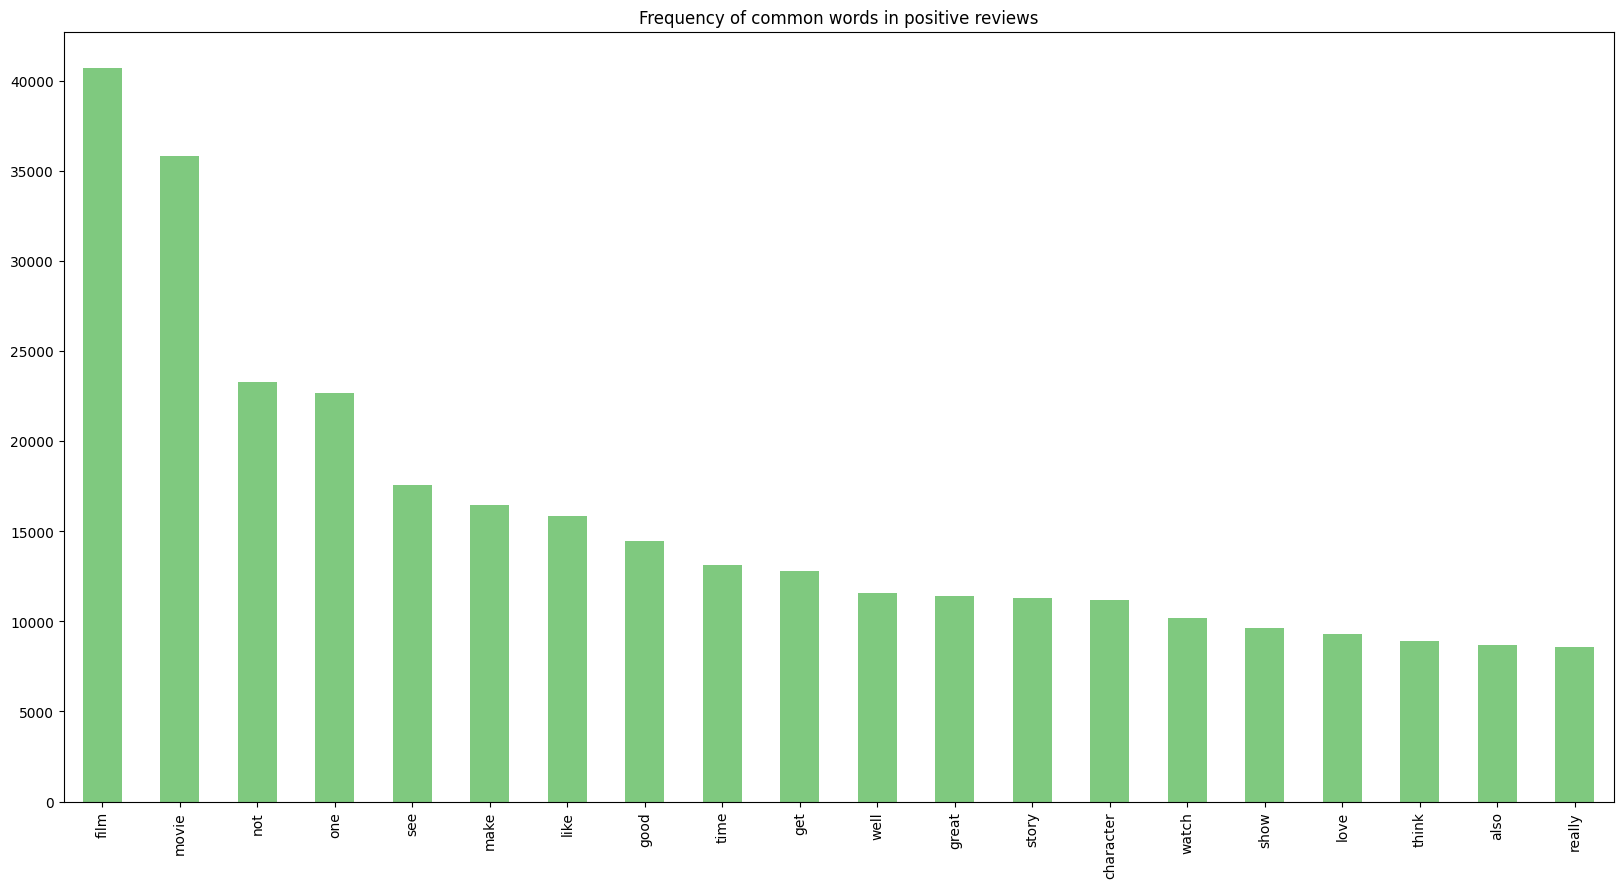

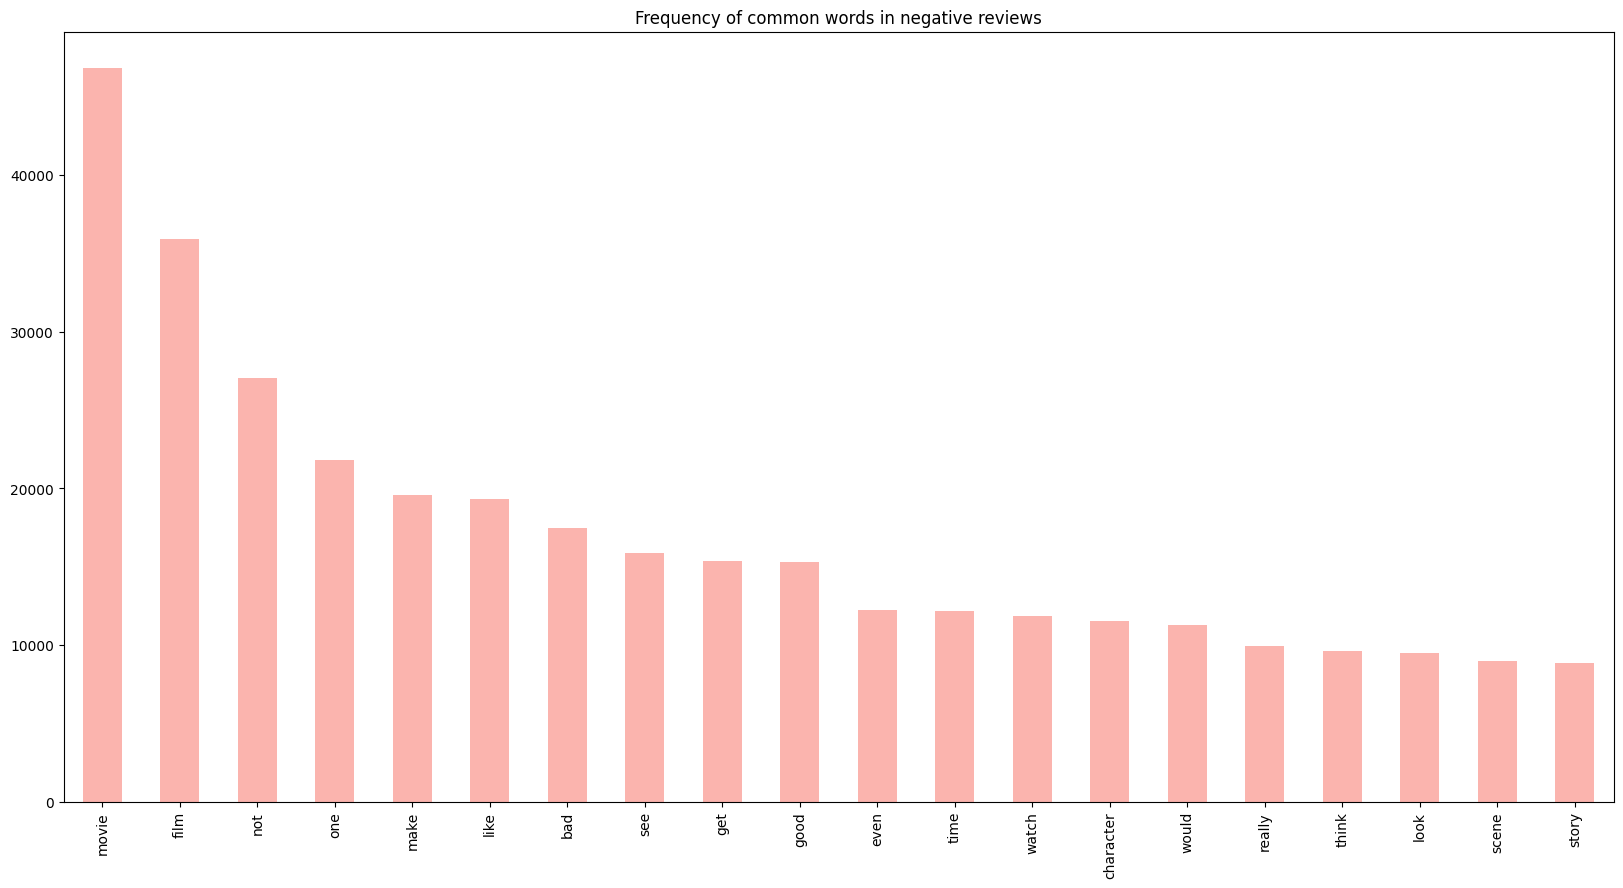

In [20]:
PosRev = sentiment[sentiment['sentiment']=='positive']['cleaned_review']
NegRev = sentiment[sentiment['sentiment']=='negative']['cleaned_review']

colors = ['Accent','Pastel1']
data = [PosRev,NegRev]
labels = ['positive','negative']
for item in range(2):
    plt.figure(figsize=(20,10))
    pd.Series(' '.join([i for i in data[item]]).split()).value_counts().head(20).plot(kind='bar',colormap=colors[item])
    plt.title(f"Frequency of common words in {labels[item]} reviews")
    plt.show()

Above graph we can see that top 3 words `"movie", "film", "one"...` has nothing to with the sentiment but very frequently repeated. So let's remove those words for better perfomance.


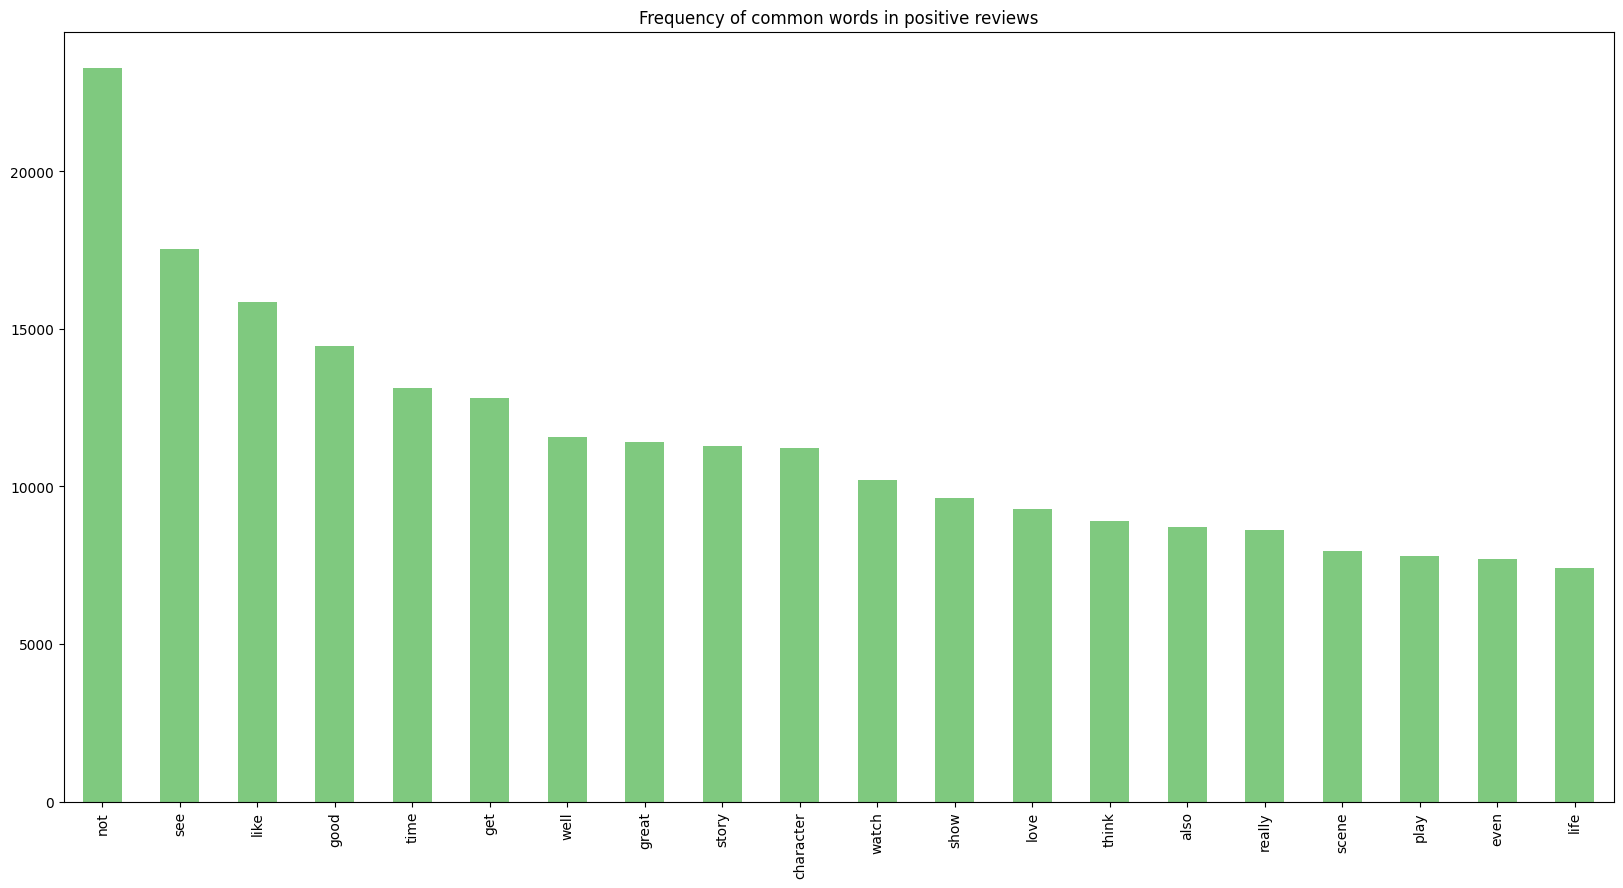

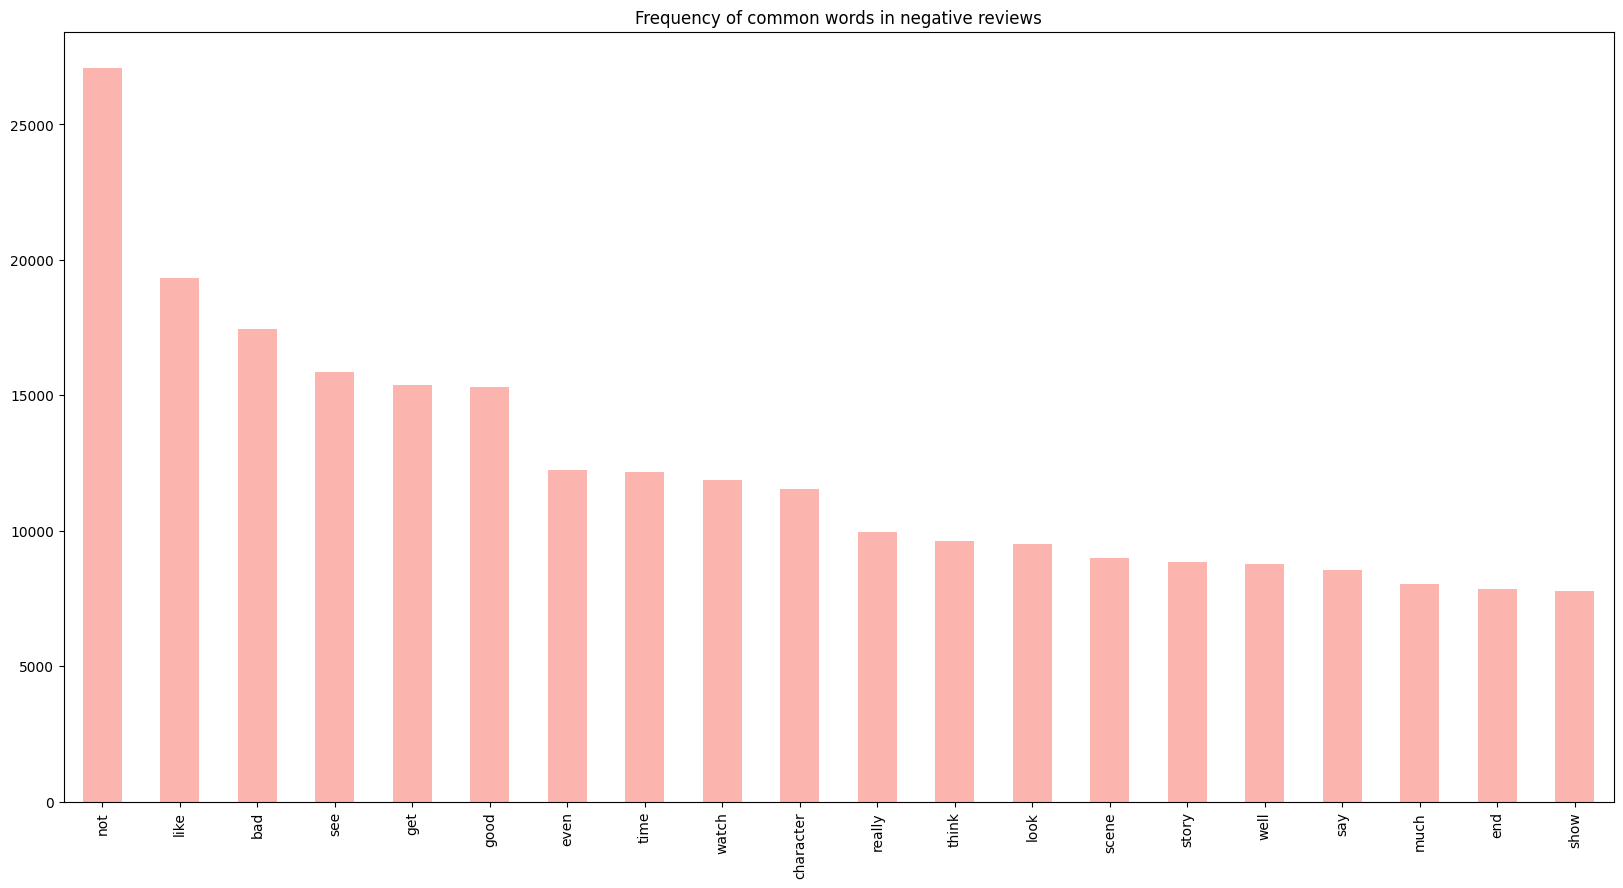

In [21]:
words_del = 'movie film one make would'.split()
def remove_freq_words(review:str):
    return ' '.join([i for i in review.split() if i not in words_del])
sentiment['cleaned_review'] = sentiment['cleaned_review'].apply(lambda text: remove_freq_words(text))

PosRev = sentiment[sentiment['sentiment']=='positive']['cleaned_review']
NegRev = sentiment[sentiment['sentiment']=='negative']['cleaned_review']

colors = ['Accent','Pastel1']
data = [PosRev,NegRev]
labels = ['positive','negative']
for item in range(2):
    plt.figure(figsize=(20,10))
    pd.Series(' '.join([i for i in data[item]]).split()).value_counts().head(20).plot(kind='bar',colormap=colors[item])
    plt.title(f"Frequency of common words in {labels[item]} reviews")
    plt.show()

Splitting to train and test part for further analysis (shapes before vectorization)

In [39]:
sentiment['sentiment'] = sentiment['sentiment'].replace({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(sentiment['cleaned_review'],sentiment['sentiment'],test_size=0.1,shuffle=True)
print(f'{X_train.shape}\n{X_test.shape}\n{y_train.shape}\n{y_test.shape}')

(36000,)
(4000,)
(36000,)
(4000,)


For vectorization let's use weighted Bag-Of-Words (with TF-IDF) and wighted N-Grams (with TF-IDF) techniques:
1. TF-IDF is usefull as it gives more weight most frequent words and less weight to least frequent words `(we have same situation here: so many rare words and much more common words)`
2. N-Grams is also very powerfull technique so here we try to find best `N` value.

Let's use Logistic Regression model as our baseline model and compare unigrams and bigrams perfomances.

- Unigram analysis

In [80]:
#Takes 7k most frequent words and appeared as a unigrams (ngram_range = (1,1)) applying BOW technique
unigram_vec = TfidfVectorizer(max_features = 7000,)
X_train_unigram = unigram_vec.fit_transform(X_train).toarray() # fit and transform train
X_test_unigram = unigram_vec.transform(X_test).toarray() # transform test

In [81]:
model = LogisticRegression()
model.fit(X_train_unigram, y_train)
predictions = model.predict(X_test_unigram)
logistic_regression_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy}")
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Logistic Regression Accuracy: 0.885
Logistic Regression Accuracy: 88.50%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      2020
           1       0.87      0.90      0.89      1980

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.88      4000
weighted avg       0.89      0.89      0.88      4000



- Bigram analysis

In [82]:
#Takes 7k most frequent words and appeared as a bigrams (ngram_range = (2,2)) applying BOW technique
bigram_vec = TfidfVectorizer(max_features=7000, ngram_range=(2,2))
X_train_bigram = bigram_vec.fit_transform(X_train).toarray()
X_test_bigram = bigram_vec.transform(X_test).toarray()

model1 = LogisticRegression()
model1.fit(X_train_bigram, y_train)
predictions = model1.predict(X_test_bigram)
logistic_regression_accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Logistic Regression Accuracy: {logistic_regression_accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Logistic Regression Accuracy: 80.85%
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      2020
           1       0.79      0.83      0.81      1980

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



*Well, TF-IDF vectorization along with BOW as unigrams overperfomed bigram ones and this is logical because importance of every word is more essential than the relationship between words in this case(sentiment analysis)*

## Modeling 

What models will be included:
- Logistic Regression (as baseline model)
- Random Forest Classifier
- NN model

### Logistic Regression Model

In [88]:
#Penalizing with ridge and lasso 
log_cls = LogisticRegression()
param_grid = {
   'penalty': ['l1', 'l2']    
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=log_cls, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_unigram, y_train)

# Print the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluating the model with the best hyperparameters on the test set
best_logistic_regression_model = grid_search.best_estimator_
y_pred = best_logistic_regression_model.predict(X_test_unigram)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test,y_pred)
print(f"Logistic Regression Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", report)

Best Hyperparameters: {'penalty': 'l2'}
Logistic Regression Accuracy: 88.50%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      2020
           1       0.87      0.90      0.89      1980

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.88      4000
weighted avg       0.89      0.89      0.88      4000



### Random Forest Classifier

In [95]:
cvec = CountVectorizer()
X_train_count = cvec.fit_transform(X_train)
X_test_count = cvec.transform(X_test)

In [96]:
rfcls = RandomForestClassifier(n_jobs=-1, verbose=1)
rfcls.fit(X_train_count, y_train)
predictions = rfcls.predict(X_test_count)
rf_acc = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"RF Model accuracy: {rf_acc * 100:.2f}%")
print("Classification Report:\n", report)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s


RF Model accuracy: 85.08%
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      2020
           1       0.85      0.84      0.85      1980

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


### NN Model

In [100]:
max_words = 10000  # Maximum number of words to keep in the vocabulary
max_len = 100  # Maximum length of input sequences

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_sequences = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post')
X_test_sequences = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')

In [101]:
# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [105]:
model.fit(X_train_sequences, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1013/1013 [==============================] - 9s 9ms/step - loss: 0.0141 - accuracy: 0.9953 - val_loss: 0.6844 - val_accuracy: 0.8675
Epoch 2/10
1013/1013 [==============================] - 9s 9ms/step - loss: 0.0151 - accuracy: 0.9950 - val_loss: 0.7826 - val_accuracy: 0.8678
Epoch 3/10
1013/1013 [==============================] - 9s 9ms/step - loss: 0.0149 - accuracy: 0.9947 - val_loss: 0.7965 - val_accuracy: 0.8608
Epoch 4/10
1013/1013 [==============================] - 9s 9ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.9700 - val_accuracy: 0.8586
Epoch 5/10
1013/1013 [==============================] - 9s 9ms/step - loss: 0.0123 - accuracy: 0.9958 - val_loss: 0.9339 - val_accuracy: 0.8481
Epoch 6/10
1013/1013 [==============================] - 9s 9ms/step - loss: 0.0110 - accuracy: 0.9961 - val_loss: 0.9226 - val_accuracy: 0.8586
Epoch 7/10
1013/1013 [==============================] - 10s 9ms/step - loss: 0.0067 - accuracy: 0.9977 - val_loss: 1.2142 - val_accuracy

Evaluating on test data

In [117]:
model.evaluate(X_test_sequences,y_test)


125/125 [==============================] - 0s 2ms/step - loss: 1.3104 - accuracy: 0.8633


[1.3104448318481445, 0.8632500171661377]

*Summary: Among 3 models above Logistic Regression models over perfomed and can be chosen as our final model*